### How well can matchplay statistics accurately classify match winners and losers?

In [1501]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import random


urls = []
for u in np.arange(16,24,1):
    urls.append(f'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_20{u}.csv')

df = pd.concat([pd.read_csv(url) for url in urls])
df.columns = [re.sub("^w_", "winner_", re.sub("^l_", "loser_", df.columns[c])) for c in np.arange(len(df.columns))]

# encode counties as binary
countries_encoded = pd.get_dummies(df[['winner_ioc', 'loser_ioc']])
metadata = df[list(filter(re.compile('.*name').match, df.columns))]

#create unique match ID
df['match_id'] = df['tourney_id'].astype(str) + df['match_num'].astype(str)

df = df[df.tourney_level != 'D'] # exclude Davis Cup
df.sort_values(by=['tourney_date', 'tourney_id', 'match_num'], inplace=True)
df.groupby(['winner_id']).cumcount().add(1).reset_index().drop('index', axis = 1)
df = df.reset_index().drop('index', axis = 1)

df['match_number_absolute'] = [i for i in np.arange(len(df))]

df['p0_id'] = df[['winner_id']]
df['p1_id'] = df[['loser_id']]

In [1606]:
df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,loser_bpSaved,loser_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,match_id,match_number_absolute,p0_id,p1_id
0,2016-0451,Doha,Hard,32,A,20160104,270,104745,2.0,NaN,...,4.0,9.0,5.0,5230.0,67.0,734.0,2016-0451270,0,104745,105807
1,2016-0451,Doha,Hard,32,A,20160104,271,104898,NaN,NaN,...,10.0,16.0,66.0,740.0,195.0,254.0,2016-0451271,1,104898,106234
2,2016-0451,Doha,Hard,32,A,20160104,272,105723,NaN,NaN,...,0.0,4.0,79.0,663.0,114.0,520.0,2016-0451272,2,105723,104947
3,2016-0451,Doha,Hard,32,A,20160104,273,105575,NaN,NaN,...,12.0,19.0,85.0,641.0,29.0,1360.0,2016-0451273,3,105575,104312
4,2016-0451,Doha,Hard,32,A,20160104,274,105011,NaN,NaN,...,2.0,6.0,94.0,605.0,7.0,4305.0,2016-0451274,4,105011,103970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19293,2023-7480,Los Cabos,Hard,32,A,20230731,296,106432,4,NaN,...,6.0,9.0,15.0,2225.0,113.0,562.0,2023-7480296,19293,106432,125802
19294,2023-7480,Los Cabos,Hard,32,A,20230731,297,126774,1,NaN,...,3.0,6.0,5.0,4850.0,28.0,1339.0,2023-7480297,19294,126774,111797
19295,2023-7480,Los Cabos,Hard,32,A,20230731,298,200282,5,NaN,...,2.0,9.0,19.0,1945.0,84.0,708.0,2023-7480298,19295,200282,136440
19296,2023-7480,Los Cabos,Hard,32,A,20230731,299,126774,1,NaN,...,2.0,5.0,5.0,4850.0,15.0,2225.0,2023-7480299,19296,126774,106432


In [1502]:
dummies = pd.DataFrame()

for v,f in zip([df.winner_id, df.loser_id, df.loser_hand, df.winner_hand, df.surface], ['winner_id', 'loser_id', 'loser_hand', 'winner_hand', 'surface']):
    dummies = pd.concat([dummies, pd.get_dummies(v, prefix=f).astype(int)], axis = 1)

df_with_dummies = pd.concat([
    df,
    dummies,
    pd.DataFrame({'winner_id_' + str(l): [0 for i in np.arange(len(df))] for l in df.loser_id.unique() if l not in df.winner_id.unique()}),
    pd.DataFrame({'loser_id_' + str(w): [0 for i in np.arange(len(df))] for w in df.winner_id.unique() if w not in df.loser_id.unique()})
    ], axis = 1)

df_with_dummies

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,winner_id_209405,winner_id_212021,winner_id_126533,winner_id_208659,winner_id_207785,winner_id_209259,winner_id_202261,winner_id_208118,winner_id_208300,winner_id_109734
0,2016-0451,Doha,Hard,32,A,20160104,270,104745,2.0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2016-0451,Doha,Hard,32,A,20160104,271,104898,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2016-0451,Doha,Hard,32,A,20160104,272,105723,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2016-0451,Doha,Hard,32,A,20160104,273,105575,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,2016-0451,Doha,Hard,32,A,20160104,274,105011,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19293,2023-7480,Los Cabos,Hard,32,A,20230731,296,106432,4,NaN,...,0,0,0,0,0,0,0,0,0,0
19294,2023-7480,Los Cabos,Hard,32,A,20230731,297,126774,1,NaN,...,0,0,0,0,0,0,0,0,0,0
19295,2023-7480,Los Cabos,Hard,32,A,20230731,298,200282,5,NaN,...,0,0,0,0,0,0,0,0,0,0
19296,2023-7480,Los Cabos,Hard,32,A,20230731,299,126774,1,NaN,...,0,0,0,0,0,0,0,0,0,0


In [1610]:
# match_pre_data = np.array()
matchplay_stats =  df_with_dummies[list(filter(re.compile(r'winner_|loser_|grass|clay|hard|p._id|match_number_absolute').match, df_with_dummies.columns))]

matchplay_stats = matchplay_stats.filter(regex = r'^(?!.*(?:seed$|entry$|name$|ioc$|hand$|winner_id$|loser_id$))' , axis = 1)

# matchplay_stats.dropna(inplace=True)

# randomly assign which player the winner will be
matchplay_stats['winner-position'] = [random.randint(0,1) for r in np.arange(len(matchplay_stats))]

# move player 1 losers to the winners columns and rename them to reflect player 1, vice versa for player 2 winners

losers = matchplay_stats[matchplay_stats['winner-position'] == 1]
winners = matchplay_stats[matchplay_stats['winner-position'] == 0]

# Rename the columns
losers.columns = [re.sub('winner_', 'p1_', re.sub('loser_', 'p0_', losers.columns[i])) for i in np.arange(len(losers.columns))]
winners.columns = [re.sub('winner_', 'p0_', re.sub('loser_', 'p1_', winners.columns[i])) for i in np.arange(len(winners.columns))]

matchplay_stats = pd.concat([losers, winners], axis = 0)

# feature_indices = np.arange(len(matchplay_stats.columns))

# features_dict = {f: matchplay_stats.columns[f] for f in feature_indices}

# matchplay_stats.columns = [f for f in feature_indices]

# print(features_dict)
matchplay_stats

,p1_ht,p1_age,p0_ht,p0_age,p1_ace,p1_df,p1_svpt,p1_1stIn,p1_1stWon,p1_2ndWon,...,p1_id_212021,p1_id_126533,p1_id_208659,p1_id_207785,p1_id_209259,p1_id_202261,p1_id_208118,p1_id_208300,p1_id_109734,winner-position
1,190.0,28.7,185.0,22.3,4.0,1.0,102.0,58.0,38.0,25.0,...,0,0,0,0,0,0,0,0,0,1
3,175.0,25.5,190.0,31.8,2.0,1.0,78.0,50.0,31.0,13.0,...,0,0,0,0,0,0,0,0,0,1
4,185.0,28.3,175.0,33.7,4.0,4.0,102.0,61.0,47.0,22.0,...,0,0,0,0,0,0,0,0,0,1
7,188.0,28.8,NaN,20.7,3.0,1.0,34.0,21.0,19.0,6.0,...,0,0,0,0,0,0,0,0,0,1
12,188.0,28.6,178.0,34.5,3.0,4.0,57.0,36.0,29.0,9.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19289,NaN,27.3,198.0,27.8,4.0,6.0,89.0,58.0,51.0,17.0,...,0,0,0,0,0,0,0,0,0,0
19290,206.0,38.2,193.0,24.9,7.0,3.0,61.0,38.0,25.0,8.0,...,0,0,0,0,0,0,0,0,0,0
19293,193.0,29.4,188.0,26.7,1.0,4.0,55.0,29.0,22.0,11.0,...,0,0,0,0,0,0,0,0,0,0
19294,198.0,27.8,193.0,24.9,9.0,1.0,103.0,71.0,49.0,18.0,...,0,0,0,0,0,0,0,0,0,0


In [1611]:
all_player_matches = (
    pd.concat([
        matchplay_stats[['p0_id', 'match_number_absolute']].rename(columns={'p0_id': 'player_id'}),
        matchplay_stats[['p1_id', 'match_number_absolute']].rename(columns={'p1_id': 'player_id'})
    ], axis=0)
    .sort_values(['player_id', 'match_number_absolute'])
    .groupby('player_id')
    .apply(lambda df: df.assign(previous_match_number=df['match_number_absolute'].shift(1)))
    .reset_index(drop=True)
)

matchplay_stats_previous = (matchplay_stats.merge(
    all_player_matches, how='left', left_on=['p0_id','match_number_absolute'], right_on=['player_id','match_number_absolute'])
    .rename(columns={'previous_match_number':'p0_previous_match_number'}).drop(['player_id'], axis=1)
    .merge(
        all_player_matches, how='left', left_on=['p1_id','match_number_absolute'], right_on=['player_id','match_number_absolute'])
        .rename(columns={'previous_match_number':'p1_previous_match_number'})).drop(['player_id'], axis=1)

matchplay_stats_previous = (matchplay_stats_previous.merge(
    matchplay_stats, how='left', left_on=['p0_previous_match_number'], right_on=['match_number_absolute'], suffixes=('', '_previous_p0'))
    .rename(columns={'previous_match_number':'p0_previous_match_number'}))

matchplay_stats_previous = (matchplay_stats_previous.merge(
    matchplay_stats, how='left', left_on=['p1_previous_match_number'], right_on=['match_number_absolute'], suffixes=('', '_previous_p1'))
    .rename(columns={'previous_match_number':'p1_previous_match_number'})).reset_index(drop=True)

# matchplay_stats_x.columns
matchplay_stats_previous


,p1_ht,p1_age,p0_ht,p0_age,p1_ace,p1_df,p1_svpt,p1_1stIn,p1_1stWon,p1_2ndWon,...,p1_id_212021_previous_p1,p1_id_126533_previous_p1,p1_id_208659_previous_p1,p1_id_207785_previous_p1,p1_id_209259_previous_p1,p1_id_202261_previous_p1,p1_id_208118_previous_p1,p1_id_208300_previous_p1,p1_id_109734_previous_p1,winner-position_previous_p1
0,190.0,28.7,185.0,22.3,4.0,1.0,102.0,58.0,38.0,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,175.0,25.5,190.0,31.8,2.0,1.0,78.0,50.0,31.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,185.0,28.3,175.0,33.7,4.0,4.0,102.0,61.0,47.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,188.0,28.8,NaN,20.7,3.0,1.0,34.0,21.0,19.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,188.0,28.6,178.0,34.5,3.0,4.0,57.0,36.0,29.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19293,NaN,27.3,198.0,27.8,4.0,6.0,89.0,58.0,51.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19294,206.0,38.2,193.0,24.9,7.0,3.0,61.0,38.0,25.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19295,193.0,29.4,188.0,26.7,1.0,4.0,55.0,29.0,22.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19296,198.0,27.8,193.0,24.9,9.0,1.0,103.0,71.0,49.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1647]:
matchplay_stats_previous_only = pd.DataFrame(
    matchplay_stats_previous[[col for col in matchplay_stats_previous.columns if re.search('.*previous',col)]])

matchplay_stats_previous_only = matchplay_stats_previous_only[[col for col in matchplay_stats_previous_only.columns if not re.search('.*id.*',col)]]

matchplay_stats_previous_only.insert(0, 'winner-position', matchplay_stats_previous[['winner-position']])

matchplay_stats_previous_only = matchplay_stats_previous_only.dropna(subset='p0_previous_match_number')

matchplay_stats_previous_only = matchplay_stats_previous_only.dropna()

matchplay_stats_current_only = pd.DataFrame(
    matchplay_stats_previous[[col for col in matchplay_stats_previous.columns if not re.search('.*previous.*',col)]])

matchplay_stats_current_only = matchplay_stats_current_only[[col for col in matchplay_stats_current_only.columns if re.search('.*rank.*|.*match.*',col)]]

matchplay_stats_current_only = matchplay_stats_current_only.dropna()

matchplay_stats_current_only.insert(0, 'winner-position', matchplay_stats_previous[['winner-position']])
matchplay_stats_current_only.insert(0, '0_better_rank', (matchplay_stats_current_only.p1_rank > matchplay_stats_current_only.p0_rank).astype(int))

print(matchplay_stats_current_only.iloc[0:10,1:3])
print(df.iloc[0:10,-8:-5])

   winner-position  p1_rank
0                1     66.0
1                1     85.0
2                1     94.0
3                1     31.0
4                1     35.0
5                1     64.0
6                1     49.0
7                1     79.0
8                1     94.0
9                1      6.0
   winner_rank  winner_rank_points  loser_rank
0          5.0              5230.0        67.0
1         66.0               740.0       195.0
2         79.0               663.0       114.0
3         85.0               641.0        29.0
4         94.0               605.0         7.0
5         50.0               863.0        58.0
6         95.0               604.0        54.0
7         31.0              1255.0      1512.0
8         75.0               681.0        17.0
9        102.0               568.0        43.0


In [1649]:
matchplay_stats_current_only['upset'] = matchplay_stats_current_only['0_better_rank'] != matchplay_stats_current_only['winner-position']
matchplay_stats_current_only
# sum(matchplay_stats_current_only.upset) / len(matchplay_stats_current_only.upset)

,0_better_rank,winner-position,p1_rank,p1_rank_points,p0_rank,p0_rank_points,match_number_absolute,upset
0,0,1,66.0,740.0,195.0,254.0,1,True
1,1,1,85.0,641.0,29.0,1360.0,3,False
2,1,1,94.0,605.0,7.0,4305.0,4,False
3,0,1,31.0,1255.0,1512.0,3.0,7,True
4,0,1,35.0,1150.0,97.0,591.0,12,True
...,...,...,...,...,...,...,...,...
19293,1,0,144.0,437.0,28.0,1339.0,19289,True
19294,1,0,114.0,560.0,5.0,4850.0,19290,True
19295,1,0,113.0,562.0,15.0,2225.0,19293,True
19296,1,0,28.0,1339.0,5.0,4850.0,19294,True


In [1613]:
# compare algorithms
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# Load dataset
# Split-out validation dataset
array = matchplay_stats_current_only.values
X = array[:,1:len(array[0]) - 1]
y = array[:,0]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1, shuffle=True)
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

LR: 0.636861 (0.009341)
LDA: 0.637835 (0.008257)
KNN: 0.589096 (0.010063)
CART: 0.560825 (0.009195)
NB: 0.624707 (0.008138)


KeyboardInterrupt: 

In [1603]:
# make predictions
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
# Load dataset

# Split-out validation dataset
array = matchplay_stats_current_only.values
X = array[:,1:len(array[0]) - 1]
y = array[:,0]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)
# Make predictions on validation dataset
model = LogisticRegression(solver='liblinear', multi_class='ovr')
# model = LogisticRegression(solver='liblinear', multi_class='ovr')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)
# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.6127858627858628
[[1327  556]
 [ 934 1031]]
              precision    recall  f1-score   support

         0.0       0.59      0.70      0.64      1883
         1.0       0.65      0.52      0.58      1965

    accuracy                           0.61      3848
   macro avg       0.62      0.61      0.61      3848
weighted avg       0.62      0.61      0.61      3848



In [703]:
model.coef_

array([[ 0.10538956, -0.10952386, -0.02720576,  0.0090545 ,  0.0045141 ,
         0.24133857,  0.02352859, -0.63629567, -0.60549316,  0.03245773,
        -0.57117326,  0.65180197]])

In [603]:
validation =  pd.DataFrame(X_validation)
validation['winner'] = Y_validation
validation['predicted_winner'] = predictions

In [418]:
upsets = validation[(validation[9] > 0) & (validation['winner'] == 1) | (validation[9] < 0) & (validation['winner'] == 0)]
as_expected = validation[(validation[9] < 0) & (validation['winner'] == 1) | (validation[9] > 0) & (validation['winner'] == 0)]



In [419]:
as_expected

,0,1,2,3,4,5,6,7,8,9,winner,predicted_winner
0,0.0,-2.0,10.0,0.0,6.0,8.0,0.0,0.0,-3.0,-62.0,1.0,1.0
1,-11.0,-3.0,-3.0,3.0,-4.0,-9.0,-1.0,3.0,5.0,37.0,0.0,0.0
2,2.0,-4.0,9.0,12.0,9.0,3.0,0.0,0.0,-3.0,-106.0,1.0,1.0
3,-5.0,-1.0,3.0,9.0,-1.0,-5.0,-1.0,-0.0,1.0,15.0,0.0,0.0
5,-1.0,-2.0,11.0,11.0,14.0,-5.0,0.0,4.0,3.0,-39.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1346,-2.0,-0.0,5.0,-4.0,-7.0,2.0,-1.0,1.0,3.0,343.0,0.0,0.0
1347,-7.0,-1.0,-4.0,-1.0,-8.0,2.0,-0.0,-2.0,-1.0,25.0,0.0,0.0
1349,6.0,3.0,-2.0,2.0,5.0,-1.0,0.0,1.0,-1.0,-26.0,1.0,1.0
1351,-4.0,5.0,11.0,-4.0,-7.0,6.0,-0.0,3.0,6.0,40.0,0.0,0.0


In [421]:
# you need to make this more straghtforward with regard to who won, whether it's an upset, what the sign of the stats mean, etc.

as_expected.loc[:,'predicted_by_model'] = as_expected['winner'] == as_expected['predicted_winner']
upsets.loc[:,'predicted_by_model'] = upsets['winner'] == upsets['predicted_winner']

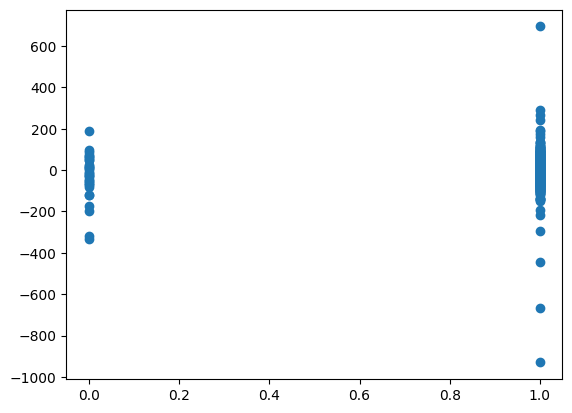

In [422]:
plt.scatter(upsets['predicted_by_model'], upsets[9])


In [426]:

results

[array([0.96125461, 0.95009242, 0.95933457, 0.95378928, 0.94454713,
        0.95378928, 0.95378928, 0.94639556, 0.95378928, 0.95009242]),
 array([0.97232472, 0.95194085, 0.96118299, 0.95563771, 0.94454713,
        0.94824399, 0.95009242, 0.94824399, 0.94824399, 0.95009242]),
 array([0.86162362, 0.90573013, 0.90203327, 0.87615527, 0.84842884,
        0.89279113, 0.8909427 , 0.89279113, 0.89648799, 0.87060998]),
 array([0.90405904, 0.90942699, 0.88724584, 0.89648799, 0.88539741,
        0.9038817 , 0.91312384, 0.90018484, 0.89833641, 0.86876155]),
 array([0.85055351, 0.85767098, 0.85767098, 0.84288355, 0.85397412,
        0.85767098, 0.87245841, 0.85397412, 0.8650647 , 0.86691312]),
 array([0.59225092, 0.6155268 , 0.59704251, 0.61182994, 0.56746765,
        0.60998152, 0.60443623, 0.59149723, 0.60628466, 0.59334566])]

In [ ]:
# Tennis databases, files, and algorithms by Jeff Sackmann / Tennis Abstract is licensed under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License.
# Based on a work at https://github.com/JeffSackmann.

## Two rows per match

In [937]:
# for each predictor, calculate the difference between the player 0 and player 1 value, and append it to new df

num_preds = int((len(matchplay_stats.columns) / 2) - 1)

matchplay_stats_winners = pd.concat([matchplay_stats.iloc[:,0:num_preds], surfaces,  pd.DataFrame({'won':[1 for i in winner_id]}), winner_id, match_id], axis = 1)
matchplay_stats_losers = pd.concat([matchplay_stats.iloc[:,num_preds:num_preds * 2], surfaces, pd.DataFrame({'won':[0 for i in loser_id]}), loser_id,  match_id], axis = 1)
matchplay_stats_winners.columns,matchplay_stats_losers.columns = [[re.sub("w_|l_|winner_", "", matchplay_stats_winners.columns[i]) for i in np.arange(len(matchplay_stats_losers.columns))] for j in [0,1]]
matchplay_stats_long = pd.concat([matchplay_stats_winners,matchplay_stats_losers], axis = 0, ignore_index=True).rename(columns={'id':'player_id'})
matchplay_stats_long.insert(len(matchplay_stats_long.columns) - 1, 'player_match', matchplay_stats_long.groupby('player_id').cumcount())
matchplay_stats_long.dropna(inplace=True)
# add tourney_date, match_number, then aggregate with indices for order of play within play

print(matchplay_stats_long.describe())
matchplay_stats_long.head(10)

                ace            df          svpt         1stIn        1stWon  \
count  20970.000000  20970.000000  20970.000000  20970.000000  20970.000000   
mean       6.209108      2.951741     81.168050     50.632570     36.060897   
std        5.539406      2.463537     29.474731     19.467142     14.322084   
min        0.000000      0.000000      4.000000      2.000000      0.000000   
25%        2.000000      1.000000     59.000000     36.000000     26.000000   
50%        5.000000      2.000000     76.000000     47.000000     34.000000   
75%        9.000000      4.000000     98.000000     61.000000     44.000000   
max       67.000000     26.000000    244.000000    161.000000    106.000000   

             2ndWon         SvGms       bpSaved       bpFaced           won  \
count  20970.000000  20970.000000  20970.000000  20970.000000  20970.000000   
mean      15.444158     12.689700      4.168050      6.853362      0.500000   
std        6.839532      4.273172      3.288516    

,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,surface,won,player_id,player_match,match_id
0,6.0,0.0,63.0,41.0,33.0,13.0,11.0,1.0,1.0,Hard,1.0,105732.0,0.0,2019-0451-270
1,8.0,0.0,48.0,34.0,30.0,8.0,9.0,2.0,2.0,Hard,1.0,109739.0,0.0,2019-0451-271
2,6.0,1.0,73.0,43.0,33.0,17.0,11.0,1.0,2.0,Hard,1.0,104607.0,0.0,2019-0451-272
3,9.0,0.0,54.0,36.0,30.0,6.0,10.0,0.0,2.0,Hard,1.0,104269.0,0.0,2019-0451-273
4,5.0,3.0,56.0,42.0,35.0,6.0,9.0,1.0,1.0,Hard,1.0,106065.0,0.0,2019-0451-274
5,5.0,1.0,66.0,48.0,36.0,11.0,11.0,0.0,2.0,Hard,1.0,105550.0,0.0,2019-0451-275
6,3.0,1.0,77.0,58.0,40.0,9.0,11.0,6.0,8.0,Hard,1.0,105583.0,0.0,2019-0451-276
7,6.0,3.0,104.0,66.0,44.0,21.0,15.0,3.0,5.0,Hard,1.0,105575.0,0.0,2019-0451-277
8,3.0,2.0,51.0,34.0,27.0,12.0,9.0,2.0,2.0,Hard,1.0,105138.0,0.0,2019-0451-278
9,12.0,1.0,124.0,87.0,59.0,24.0,17.0,7.0,9.0,Hard,1.0,111797.0,0.0,2019-0451-280


In [956]:
df['match_id'].replace('-', '',regex=True, inplace=True)
df

,index,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,match_id
0,57,2019-0451,Doha,Hard,32,A,20181231,270,105732,NaN,...,23.0,13.0,10.0,1.0,3.0,55.0,903.0,8.0,4095.0,20190451270
1,56,2019-0451,Doha,Hard,32,A,20181231,271,109739,NaN,...,19.0,10.0,8.0,4.0,7.0,74.0,706.0,59.0,855.0,20190451271
2,55,2019-0451,Doha,Hard,32,A,20181231,272,104607,NaN,...,33.0,14.0,11.0,2.0,4.0,71.0,715.0,34.0,1125.0,20190451272
3,54,2019-0451,Doha,Hard,32,A,20181231,273,104269,8.0,...,21.0,14.0,9.0,7.0,11.0,28.0,1410.0,109.0,525.0,20190451273
4,53,2019-0451,Doha,Hard,32,A,20181231,274,106065,4.0,...,34.0,9.0,9.0,8.0,11.0,20.0,1819.0,134.0,424.0,20190451274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10890,1545,2023-8994,Mallorca,Grass,32,A,20230626,296,105173,4,...,31.0,12.0,10.0,5.0,9.0,43.0,972.0,80.0,723.0,20238994296
10891,1544,2023-8994,Mallorca,Grass,32,A,20230626,297,105870,NaN,...,23.0,12.0,9.0,6.0,9.0,48.0,880.0,634.0,45.0,20238994297
10892,1543,2023-8994,Mallorca,Grass,32,A,20230626,298,111153,NaN,...,54.0,18.0,15.0,6.0,7.0,77.0,738.0,298.0,177.0,20238994298
10893,1542,2023-8994,Mallorca,Grass,32,A,20230626,299,105173,4,...,28.0,16.0,11.0,1.0,4.0,43.0,972.0,48.0,880.0,20238994299


In [938]:
matchplay_stats_long = matchplay_stats_long.sort_values(['player_id','player_match']).reset_index(drop=True)
previous_match = matchplay_stats_long.groupby('player_id').shift(1).rename(columns=lambda x: 'p_' + x )

In [939]:
matchplay_stats_long = pd.concat([matchplay_stats_long, previous_match], axis=1)
matchplay_stats_long = matchplay_stats_long.loc[:,~matchplay_stats_long.columns.duplicated()]

In [943]:
matchplay_stats_long.describe()

,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,won,...,p_df,p_svpt,p_1stIn,p_1stWon,p_2ndWon,p_SvGms,p_bpSaved,p_bpFaced,p_won,p_player_match
count,20970.000000,20970.000000,20970.000000,20970.000000,20970.000000,20970.000000,20970.000000,20970.000000,20970.000000,20970.000000,...,20483.000000,20483.000000,20483.000000,20483.000000,20483.000000,20483.000000,20483.000000,20483.000000,20483.000000,20483.000000
mean,6.209108,2.951741,81.168050,50.632570,36.060897,15.444158,12.689700,4.168050,6.853362,0.500000,...,2.943465,81.111214,50.623688,36.134453,15.459942,12.692428,4.146609,6.794317,0.511839,68.727970
std,5.539406,2.463537,29.474731,19.467142,14.322084,6.839532,4.273172,3.288516,4.513998,0.500012,...,2.457912,29.365040,19.418096,14.281916,6.811816,4.258058,3.279324,4.497688,0.499872,59.206317
min,0.000000,0.000000,4.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,4.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,59.000000,36.000000,26.000000,11.000000,10.000000,2.000000,3.000000,0.000000,...,1.000000,59.000000,36.000000,26.000000,11.000000,10.000000,2.000000,3.000000,0.000000,20.000000
50%,5.000000,2.000000,76.000000,47.000000,34.000000,14.000000,12.000000,4.000000,6.000000,0.500000,...,2.000000,76.000000,47.000000,34.000000,14.000000,12.000000,4.000000,6.000000,1.000000,54.000000
75%,9.000000,4.000000,98.000000,61.000000,44.000000,19.000000,15.000000,6.000000,10.000000,1.000000,...,4.000000,97.000000,61.000000,44.000000,19.000000,15.000000,6.000000,9.000000,1.000000,103.000000
max,67.000000,26.000000,244.000000,161.000000,106.000000,56.000000,36.000000,27.000000,35.000000,1.000000,...,26.000000,244.000000,161.000000,106.000000,56.000000,36.000000,27.000000,35.000000,1.000000,306.000000


In [ ]:
#### i may actually just need to keep the losers where they are, sort by player_match # and lag all of the loser's and winner's stats.
# Then I'll have the result of each match along with each player's previous stats